In [72]:
from imports import *
from tools import *

In [73]:
root_dir = '/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH_continuum/'
input_file = '%s/cloudH_3mm_cont.fits' % root_dir
output_dir  = './dendro/'
cloud = 'cloudH'

In [74]:
print(input_file)

hdu = fits.open(input_file)[0]
hdu_ = fits.open(input_file)[0]

header = hdu.header 

del header['*4']
del header['*3']
del header['PC*']
del header['PV*']
del header['HISTORY*']
header['NAXIS'] = 2

wcs = WCS(header)
data = hdu.data
data = np.squeeze(data)
data_f = data.flatten()
data_fn = data_f[~np.isnan(data_f)]

pixsize = header['CDELT2'] *au.deg
bmaj = header['BMAJ'] *au.deg
bmin = header['BMIN'] *au.deg

pixarea = pixsize**2
bave = (bmaj*bmaj)**0.5
barea = (np.pi*bmaj*bmin)/(4.*np.log(2))
bpix = barea/pixarea

noise = stats.mad_std(hdu_.data, ignore_nan=True)
noise = stats.mad_std(hdu_.data[hdu_.data<3*noise], ignore_nan=True)
noise = stats.mad_std(hdu_.data[hdu_.data<3*noise], ignore_nan=True)

print('[INFO] noise = %0.3e mJybeam' %(noise*1e3))

/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH_continuum//cloudH_3mm_cont.fits
[INFO] noise = 3.695e-02 mJybeam


In [75]:
min_value = noise*3
min_delta = noise*1
min_npix = int(bpix)*0.5

print('[INFO] min_delta=%0.1e mJybeam' %(min_delta*1e3))
print('[INFO] min_value=%0.1e mJybeam' %(min_value*1e3))
print('[INFO] min_npix=%i' %min_npix)

dendro = Dendrogram.compute(data,
                min_delta=min_delta,
                min_value=min_value,
                min_npix=min_npix,
                wcs=wcs)

# dendro.save_to('%s/%s_dendro.fits' %(output_dir, cloud))

metadata = {}
metadata['data_unit'] = au.Jy / au.beam
metadata['spatial_scale'] =  pixsize.to('arcsec')
metadata['beam_major'] =  bmaj.to('arcsec')
metadata['beam_minor'] =  bmin.to('arcsec')

props = pp_catalog(dendro.leaves, metadata, verbose=True)
index_map = dendro.index_map
index_map = pruneleaves(index_map, props)

coords = dendro.wcs.pixel_to_world(props['x_cen'], props['y_cen'])
maxflux, meanflux = get_statsflux(props, data, index_map)
bgsubflux = get_bgsubfluxes(dendro.leaves, bpix)

R_eff = get_Reff(props['area_exact'])

props.add_column(R_eff, name='radius_eff')
props.add_column(coords.ra, name='l_cen')
props.add_column(coords.dec, name='b_cen')
props.add_column(maxflux, name='max_flux')
props.add_column(meanflux, name='mean_flux')
props.add_column(bgsubflux, name='flux_bgsub')
props['radius_deconv'] = (props['radius'].quantity**2 - (bave.to('arcsec')/2)**2)**0.5
props['radius_eff_deconv'] = (props['radius_eff'].quantity**2 - (bave.to('arcsec')/2)**2)**0.5

index_map = np.int16(index_map)
fits.writeto('%s/%s_index_map.fits' %(output_dir, cloud), data=index_map, header=header, overwrite=True)

props.sort('flux', reverse=True)
props.write('%s/%s_props.fits' %(output_dir, cloud), overwrite=True)

[INFO] min_delta=3.7e-02 mJybeam
[INFO] min_value=1.1e-01 mJybeam
[INFO] min_npix=40
Computing catalog for 16 structures

[==>                                      ] 6%
[=====>                                   ] 12%
[=======>                                 ] 18%
[==========>                              ] 25%
[============>                            ] 31%
[===============>                         ] 37%
[=================>                       ] 43%
[====================>                    ] 50%
[======================>                  ] 56%
[=========================>               ] 62%
[===========================>             ] 68%
[==============================>          ] 75%
[================================>        ] 81%
[===================================>     ] 87%
[=====================================>   ] 93%
[========================================>] 100%
[========================================>] 100%


In [76]:
props

_idx,area_ellipse,area_exact,flux,major_sigma,minor_sigma,position_angle,radius,x_cen,y_cen,radius_eff,l_cen,b_cen,max_flux,mean_flux,flux_bgsub,radius_deconv,radius_eff_deconv
,arcsec2,arcsec2,Jy,arcsec,arcsec,deg,arcsec,pix,pix,arcsec,deg,deg,Jy,Jy,Jy,arcsec,arcsec
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,54.72094206437951,133.80115492888618,0.0016471295577292842,8.851326253675433,1.4195388441356307,85.06860428317366,3.544686366832725,166.57706320634477,227.75457677311152,6.52611909151783,284.28492625721293,2.1686773169952844,0.00022730082855559886,0.0001488639973104,0.0004196120481953486,2.773023252662216,6.141261020121931
4,15.272608937358289,58.05050107340689,0.0013859440211887385,3.3689176444352675,1.04093809221819,115.48985021099094,1.8726544544145474,176.18347367799566,160.9685918244565,4.298610053213499,284.2838920186877,2.1614922595214323,0.0006257022614590824,0.00028870979440398514,0.0008528278023939571,nan,3.688211614073102
13,12.187425245230942,42.150363828494406,0.0012165254135448433,2.3755822961833957,1.1779963617546696,86.28772354381505,1.6728500536368596,163.19496879741178,346.5055009448015,3.6629056106939775,284.2852904012825,2.1814529367470543,0.0007161521352827549,0.0003490130475256592,0.0005504968642351902,nan,2.922624511196909
15,7.220000217914284,30.90026672124501,0.0009049171725102549,1.7556447968615077,0.9442839788271198,103.62268792310185,1.2875664076805962,196.03974037412934,362.86411215024395,3.136217528024527,284.2817542880557,2.1832128538239957,0.000863984867464751,0.0003541346231941134,0.0006196301672844341,nan,2.2272666889449555
14,5.961396792842189,20.40017608781224,0.0004977254820667143,1.4404707966756278,0.9502669740716603,101.01203869904121,1.1699708651054277,177.07438773473535,343.7468913838025,2.548249934492455,284.28379612387164,2.1811561586636175,0.00048290437553077936,0.0002950378693640232,0.00017719824283723157,nan,1.2721769724516923
3,7.155092958581758,21.75018774068217,0.0003842904058921341,1.9099897841665265,0.8601739786189535,124.15870817711732,1.2817657788254753,123.74452956156047,148.5266204937639,2.6312164077119577,284.28953758548073,2.1601536938596277,0.00037941246409900486,0.00021365760767366737,0.00018468684759765408,nan,1.431138115210468
16,6.86561315432977,23.400201983078748,0.0003693330756059842,1.8261383006561527,0.8632721459991375,88.55594412943417,1.2555693249274031,174.99824898684244,378.8957266901076,2.729196883684193,284.284019648347,2.184937587333267,0.0003431471122894436,0.00019086241081822664,0.00015222157835982793,nan,1.6041733542566594
11,3.5631745687628285,11.100095812486073,0.0003596277485098722,1.2637117784555605,0.6474274829541131,95.52929392525205,0.9045229327689538,185.00145873905038,324.76566065273585,1.8796995064907618,284.282942683787,2.1791140952264936,0.0005041753174737096,0.000391785433748737,7.576724578881791e-05,nan,nan


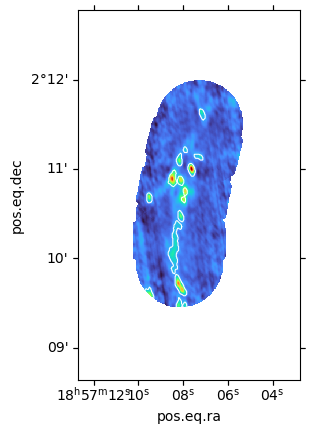

In [77]:
p = dendro.plotter()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=wcs)

ax.imshow(data, origin='lower', interpolation='nearest', cmap='turbo')

for leaf in dendro.leaves:

    p.plot_contour(ax, structure=leaf, linewidths=0.75, colors='white')
    # s = PPStatistic(leaf)
    # ellipse = s.to_mpl_ellipse(edgecolor='orange', facecolor='none')
    # ax.add_patch(ellipse)

fig.savefig('%s/%s_plot.pdf' %(output_dir, cloud), dpi=200)
# plt.close('all')